![](https://upload.wikimedia.org/wikipedia/commons/6/6e/St%C3%B6wer_Titanic.jpg)

# Titanic Top 3% (now is maybe 6%) : cluster analysis - attempts for imrovement the solution "Titanic Top 3% : one line of the prediction code" with LB = 0.83253

In [1]:

#
import pandas as pd
import numpy as np 
traindf = pd.read_csv('../input/titanic/train.csv').set_index('PassengerId')
testdf = pd.read_csv('../input/titanic/test.csv').set_index('PassengerId')
df = pd.concat([traindf, testdf], axis=0, sort=False)
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
df['LastName'] = df.Name.str.split(',').str[0]
family = df.groupby(df.LastName).Survived
df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
df['Alone'] = (df.WomanOrBoyCount == 0)
train_y = df.Survived.loc[traindf.index]
df2 = pd.concat([df.WomanOrBoySurvived.fillna(0), df.Alone, df.Sex.replace({'female': 0, 'male': 1})], axis=1)
test_x = df2.loc[testdf.index]

# The one line of the code for prediction : LB = 0.83253 (Titanic Top 3%) 
y_pred_top3 = (((test_x.WomanOrBoySurvived <= 0.238) & (test_x.Sex < 0.5) & (test_x.Alone > 0.5)) | \
          ((test_x.WomanOrBoySurvived > 0.238) & \
           ~((test_x.WomanOrBoySurvived > 0.55) & (test_x.WomanOrBoySurvived <= 0.633)))).astype(int)

# Saving the result
pd.DataFrame({'Survived': y_pred_top3}, \
             index=testdf.index).reset_index().to_csv('survived_top3.csv', index=False)
print('Mean =', y_pred_top3.mean(), ' Std =', y_pred_top3.std())

Mean = 0.3349282296650718  Std = 0.47253093702252047


# Preparing to prediction (including FE)

### Preparing to prediction (including FE) 

In [2]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
from scipy.spatial.distance import cosine

import time
import graphviz
import matplotlib.pyplot as plt
print(__doc__)

import warnings
warnings.filterwarnings("ignore")


np.random.seed(0)

Automatically created module for IPython interactive environment


In [3]:
# FE

In [4]:

#Title
df['Title'] = df['Title'].replace('Ms','Miss')
df['Title'] = df['Title'].replace('Mlle','Miss')
df['Title'] = df['Title'].replace('Mme','Mrs')

In [5]:

# Embarked
df['Embarked'] = df['Embarked'].fillna('S')

In [6]:

# Fare
med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df['Fare'] = df['Fare'].fillna(med_fare)

In [7]:

# Cabin, Deck
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'

In [8]:

#Age
df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))

In [9]:

# Family_Size
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

In [10]:
pd.set_option('max_columns',100)
traindf.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [11]:
df.WomanOrBoySurvived = df.WomanOrBoySurvived.fillna(0)
df.WomanOrBoyCount = df.WomanOrBoyCount.fillna(0)
df.FamilySurvivedCount = df.FamilySurvivedCount.fillna(0)
df.Alone = df.Alone.fillna(0)

In [12]:
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,Braund,0.0,0.0,0.0,True,M,2
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,Cumings,0.0,0.0,0.0,True,C,2
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,True,Heikkinen,0.0,0.0,0.0,True,M,1


In [13]:
train_y = df.Survived.loc[traindf.index]

In [14]:
cols_to_drop = ['Name','Ticket','Cabin','Survived']
df = df.drop(cols_to_drop, axis=1)

In [15]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = df.columns.values.tolist()
for col in features:
    if df[col].dtype in numerics: continue
    categorical_columns.append(col)
categorical_columns

['Sex', 'Embarked', 'Title', 'IsWomanOrBoy', 'LastName', 'Alone', 'Deck']

In [16]:
for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [17]:
train_x_all, test_x_all = df.loc[traindf.index], df.loc[testdf.index]
train_x_all.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size
PassengerId,,,,,,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,2,10,0,100,0.0,0.0,0.0,1,7,2
2,1,0,38.0,1,0,71.2833,0,11,1,182,0.0,0.0,0.0,1,2,2
3,3,0,26.0,0,0,7.9250,2,9,1,329,0.0,0.0,0.0,1,7,1


# Clustering

In [18]:
# The minimal percentage of similarity of the clustered feature with "Survived" for inclusion in the final dataset
limit_opt = 0.7

In [19]:
n_clusters_opt = 3 # number of clusters
default_base = {'quantile': .2,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': n_clusters_opt,
                'min_samples': 3,
                'xi': 0.05,
                'min_cluster_size': 0.05}

In [20]:
train_x_all.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title',
       'IsWomanOrBoy', 'LastName', 'WomanOrBoyCount', 'FamilySurvivedCount',
       'WomanOrBoySurvived', 'Alone', 'Deck', 'Family_Size'],
      dtype='object')

In [21]:
# Features list for clustering
feature_first = 'WomanOrBoySurvived'
clustered_features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'WomanOrBoyCount', 'Alone', 'Deck', 'Family_Size']

In [22]:
def generate_data(x1,x2,df,t):
    # x1, x2 as string - name of features from dataframe df
    # t=1 - with train_y, t=0 - without its
    X = pd.concat([df[x1], df[x2]], axis=1).values
    if t==1:
        y = train_y.values.astype(int)
        return (X, y)
    else:
        return X

In [23]:
title_plot = {}
i = -1
for features in clustered_features:
    i += 1
    if (features != 'WomanOrBoyCount') and (features != 'Family_Size'):
        title_plot[i] = 'W-' + features
    elif (features == 'WomanOrBoyCount'):
        title_plot[i] = 'W-W|B-Count'
    elif (features == 'Family_Size'):
        title_plot[i] = 'W-FamSize'
    
title_plot

{0: 'W-Pclass',
 1: 'W-Sex',
 2: 'W-Age',
 3: 'W-Fare',
 4: 'W-Embarked',
 5: 'W-Title',
 6: 'W-W|B-Count',
 7: 'W-Alone',
 8: 'W-Deck',
 9: 'W-FamSize'}

In [24]:
# train dataset
datasets = []
for i in range(len(clustered_features)):
    datasets.append((generate_data(feature_first,clustered_features[i],train_x_all,1),{}))

In [25]:
# test dataset
datasets_test = []
rez = pd.DataFrame(index = test_x.index)
for i in range(len(clustered_features)):
    datasets_test.append(generate_data(feature_first,clustered_features[i],test_x_all,0))

In [26]:
def generate_clustering_algorithms(Z,n_clusters):
    # generate clustering algorithms
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(df, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        Z, n_neighbors=params['n_neighbors'], include_self=False)
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state = 1000)
    two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'])
    average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('KMeans', kmeans),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )
    return clustering_algorithms

0 0 0.349 W-Pclass MiniBatchKMeans
0 1 0.431 W-Pclass KMeans
0 2 0.58 W-Pclass AffinityPropagation
0 3 nan W-Pclass MeanShift
0 4 0.545 W-Pclass SpectralClustering
0 5 0.606 W-Pclass Ward
0 6 0.27 W-Pclass AgglomerativeClustering
0 7 0.657 W-Pclass DBSCAN
0 8 0.525 W-Pclass OPTICS
0 9 0.445 W-Pclass Birch
0 10 0.604 W-Pclass GaussianMixture
Optimal ==>  DBSCAN
1 0 0.473 W-Sex MiniBatchKMeans
1 1 0.549 W-Sex KMeans
1 2 0.495 W-Sex AffinityPropagation
1 3 nan W-Sex MeanShift
1 4 0.403 W-Sex SpectralClustering
1 5 0.213 W-Sex Ward
1 6 0.706 W-Sex AgglomerativeClustering
1 7 0.785 W-Sex DBSCAN
1 8 0.584 W-Sex OPTICS
1 9 0.55 W-Sex Birch
1 10 0.876 W-Sex GaussianMixture
Optimal ==>  GaussianMixture
2 0 0.449 W-Age MiniBatchKMeans
2 1 0.385 W-Age KMeans
2 2 0.582 W-Age AffinityPropagation
2 3 nan W-Age MeanShift
2 4 0.069 W-Age SpectralClustering
2 5 0.446 W-Age Ward
2 6 0.118 W-Age AgglomerativeClustering
2 7 0.515 W-Age DBSCAN
2 8 0.117 W-Age OPTICS
2 9 0.321 W-Age Birch
2 10 0.619 W-Age G

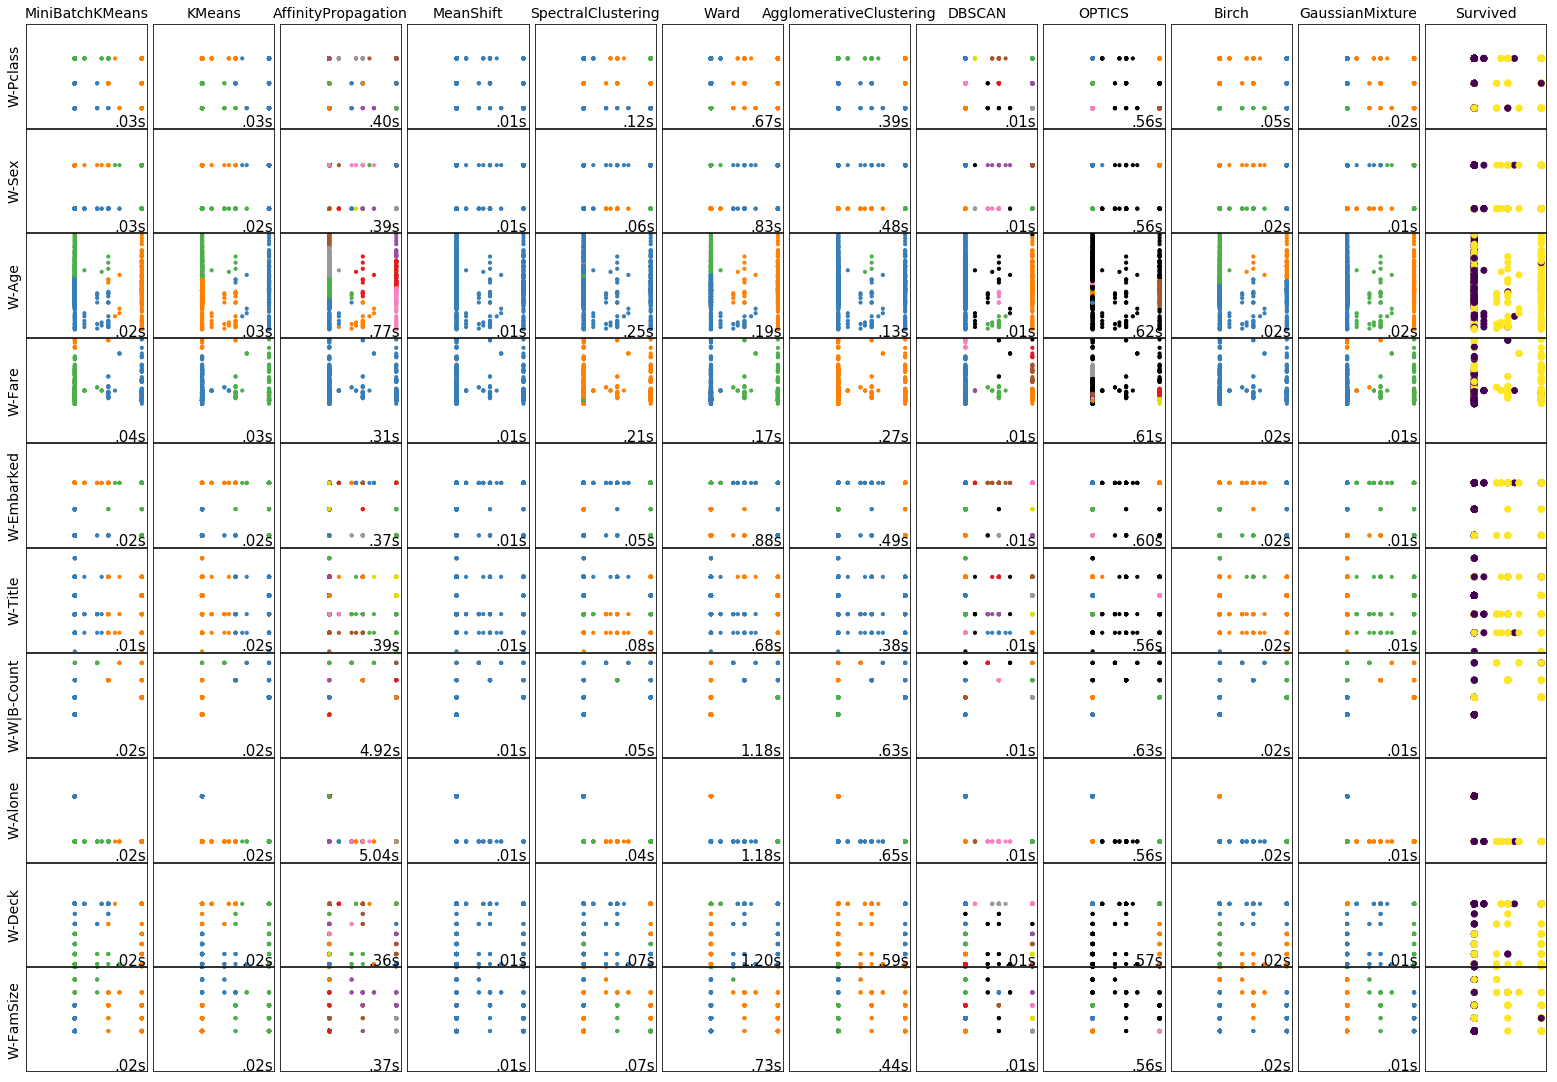

In [27]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(10 * 2 + 2, 15))
plt.subplots_adjust(left=.02, right=.98, bottom=.01, top=.98, wspace=.05,
                    hspace=.01)

plot_num = 1
coord_xy_lim = 2.5
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    datasets_test[i_dataset] = StandardScaler().fit_transform(datasets_test[i_dataset])        

    clustering_algorithms = generate_clustering_algorithms(X,params['n_clusters'])
    clustering_algorithms_test = generate_clustering_algorithms(datasets_test[i_dataset],params['n_clusters'])

    simil = {}
    i = 0

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)       
        
        simil[name] = 1 - cosine(y, y_pred)
        print(i_dataset, i, round(simil[name], 3), title_plot[i_dataset], name)

        if (i == len(clustering_algorithms)-1):
            # determine the optimal clustering method 
            max_simil = max(simil, key=simil.get)
            print('Optimal ==> ', max_simil)
           
            # clustering data by the optimal method - synthesis of a new feature
            if simil[max_simil] > limit_opt:
                train_x_all[title_plot[i_dataset]] = y_pred
                algorithm_opt = dict(clustering_algorithms_test)[max_simil]
                algorithm_opt.fit(datasets_test[i_dataset])
                if hasattr(algorithm_opt, 'labels_'):
                    rez[title_plot[i_dataset]] = algorithm_opt.labels_.astype(np.int)
                else:
                    rez[title_plot[i_dataset]] = algorithm_opt.predict(datasets_test[i_dataset])          

        plt.subplot(len(datasets), len(clustering_algorithms) + 1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)
        if name == 'MiniBatchKMeans':
            yt = plt.ylabel(title_plot[i_dataset], size=14,rotation=90)
            
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-coord_xy_lim, coord_xy_lim)
        plt.ylim(-coord_xy_lim, coord_xy_lim)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        i += 1
    # Survived
    plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
    if i_dataset == 0:
        plt.title("Survived", size=14)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlim(-coord_xy_lim, coord_xy_lim)
    plt.ylim(-coord_xy_lim, coord_xy_lim)
    plt.xticks(())
    plt.yticks(())
    plot_num += 1

plt.show()

In [28]:
rez.head(3)

,W-Sex,W-Fare,W-Embarked,W-Title,W-FamSize
PassengerId,,,,,
892,0,0,0,0,0
893,2,0,0,1,0
894,0,0,0,0,0


## Tuning model

In [29]:
train_x = pd.concat([train_x_all.WomanOrBoySurvived.fillna(0), 
                     train_x_all.Alone, 
                     train_x_all.Sex,
                     ], axis=1)
test_x = pd.concat([test_x_all.WomanOrBoySurvived.fillna(0), 
                     test_x_all.Alone, 
                     test_x_all.Sex,
                     ], axis=1)

In [30]:
rez_col = rez.columns.values.tolist()
rez_col

['W-Sex', 'W-Fare', 'W-Embarked', 'W-Title', 'W-FamSize']

In [31]:
train_x = train_x.join(train_x_all[rez_col], how='left', lsuffix="_rez")
train_x.head(2)

,WomanOrBoySurvived,Alone,Sex,W-Sex,W-Fare,W-Embarked,W-Title,W-FamSize
PassengerId,,,,,,,,
1,0.0,1,1,0,0,0,1,1
2,0.0,1,0,1,0,1,1,1


In [32]:
test_x = test_x.join(rez[rez_col], how='left', lsuffix="_rez")
test_x.head(2)

,WomanOrBoySurvived,Alone,Sex,W-Sex,W-Fare,W-Embarked,W-Title,W-FamSize
PassengerId,,,,,,,,
892,0.0,1,1,0,0,0,0,0
893,0.0,1,0,2,0,0,1,0


In [33]:
# Tuning the DecisionTreeClassifier by the GridSearchCV
parameters = {'max_depth' : np.arange(2, 9, dtype=int),
              'min_samples_leaf' :  np.arange(1, 4, dtype=int)}
classifier = DecisionTreeClassifier(random_state=1000)
model = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
model.fit(train_x, train_y)
best_parameters = model.best_params_
print(best_parameters)

{'max_depth': 5, 'min_samples_leaf': 1}


In [34]:
model=DecisionTreeClassifier(max_depth = best_parameters['max_depth'], 
                             random_state = 1118)
model.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1118, splitter='best')

### Plot tree

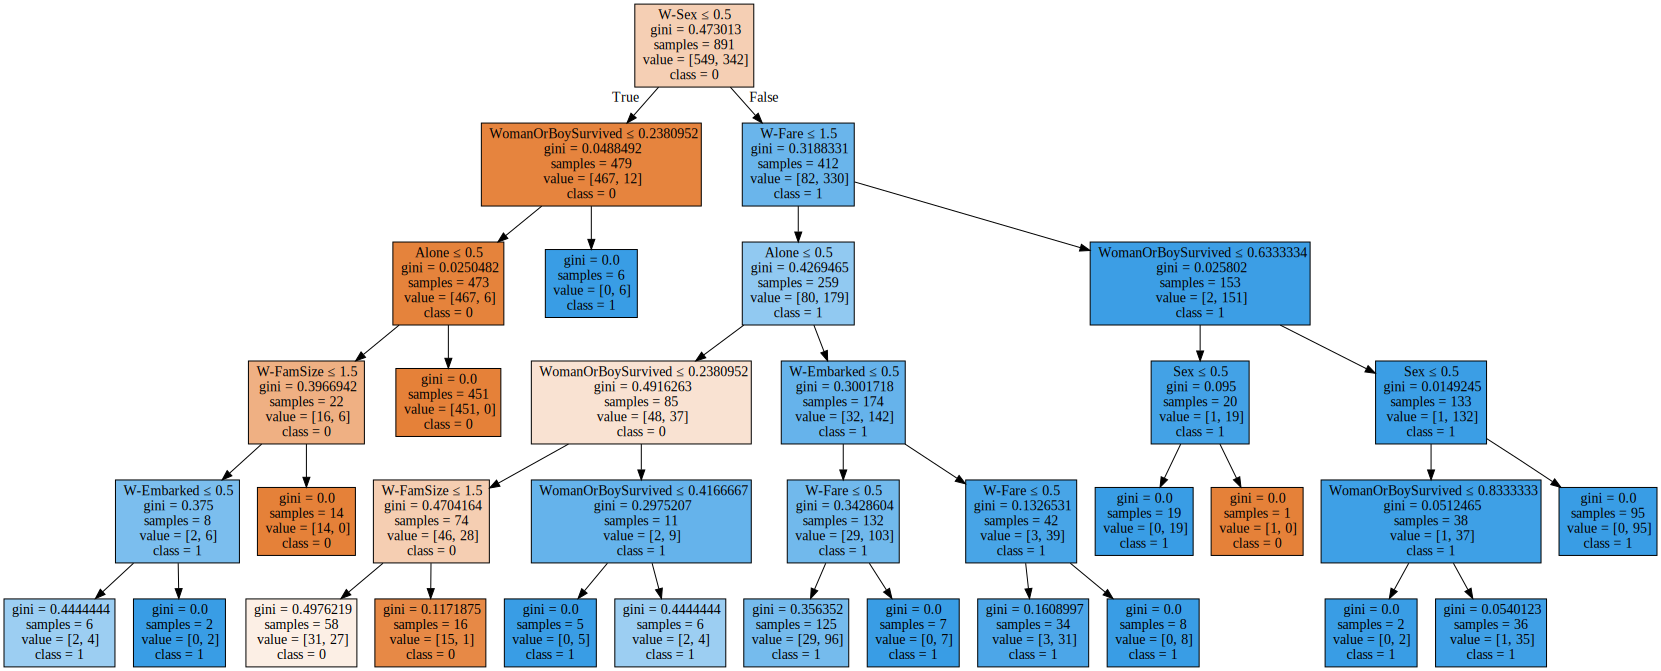

In [35]:
# plot tree
dot_data = export_graphviz(model, out_file=None, feature_names=train_x.columns, class_names=['0', '1'], 
                           filled=True, rounded=False,special_characters=True, precision=7) 
graph = graphviz.Source(dot_data)
graph 

### Prediction

In [36]:
# Prediction by the DecisionTreeClassifier
y_pred = model.predict(test_x).astype(int)
print('Mean =', y_pred.mean(), ' Std =', y_pred.std())
# Mean = 0.3349282296650718  Std = 0.4719653701687156 ==> LB = 0.83253

Mean = 0.3588516746411483  Std = 0.4796635802814216


In [37]:
train_y_pred = model.predict(train_x).astype(int)
diff = sum(abs(train_y-train_y_pred))*100/len(train_y)
diff
# LB = 0.83253 ==> 7.744107744107744 

7.295173961840629

### Saving the result

In [38]:
# Saving the result
pd.DataFrame({'Survived': y_pred}, index=testdf.index).reset_index().to_csv('survived_new.csv', index=False)

## Residues of train dataset view

In [39]:
train_x_all['Pred'] = train_y_pred
train_x_all['Survived'] = train_y

In [40]:
pd.set_option('max_columns',100)
pd.set_option('max_rows',100)

In [41]:
train_x_all[train_x_all['Survived'] != train_x_all['Pred']].sort_values(by=['Survived'])

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size,W-Sex,W-Fare,W-Embarked,W-Title,W-FamSize,Pred,Survived
PassengerId,,,,,,,,,,,,,,,,,,,,,,,
8,3,1,2.0,3,1,21.0750,2,8,1,608,4.0,0.0,0.0,0,7,5,0,0,0,1,1,1,0.0
313,2,0,26.0,1,1,26.0000,2,11,1,420,0.0,0.0,0.0,1,7,3,1,0,0,1,1,1,0.0
358,2,0,38.0,0,0,13.0000,2,9,1,266,0.0,0.0,0.0,1,7,1,1,0,0,1,1,1,0.0
397,3,0,31.0,0,0,7.8542,2,9,1,595,0.0,0.0,0.0,1,7,1,1,0,0,1,1,1,0.0
416,3,0,31.0,0,0,8.0500,2,11,1,515,0.0,0.0,0.0,1,7,1,1,0,0,1,1,1,0.0
475,3,0,22.0,0,0,9.8375,2,9,1,770,0.0,0.0,0.0,1,7,1,1,0,0,1,1,1,0.0
499,1,0,25.0,1,2,151.5500,2,11,1,16,2.0,1.0,0.5,0,2,4,1,1,2,2,2,1,0.0
502,3,0,21.0,0,0,7.7500,1,9,1,122,0.0,0.0,0.0,1,7,1,1,0,0,1,1,1,0.0
503,3,0,18.0,0,0,7.6292,1,9,1,590,0.0,0.0,0.0,1,7,1,1,0,0,1,1,1,0.0


In [42]:
diff_nrow = len(train_x_all[train_x_all['Survived'] != train_x_all['Pred']])
diff_nrow
# LB = 0.83253 ==> Top 2-3%

65